In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk


In [4]:
#Read in data (~0.57M reviews)
df = pd.read_csv('/Users/akshay/Desktop/Reviews.csv')

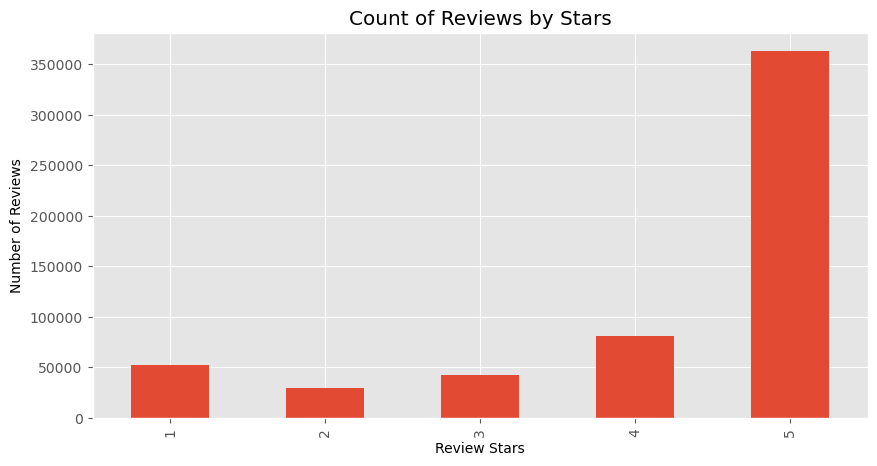

In [5]:

#Quick Exploratory Data Analysis (EDA)
plot = df['Score'].value_counts().sort_index().plot(kind = 'bar', title = 'Count of Reviews by Stars', figsize = (10, 5))
plot.set_xlabel('Review Stars')
plot.set_ylabel('Number of Reviews')
plt.show()

#Results show dataset clearly biased towards 5 star reviews

In [6]:
#Basic NLTK
example = df['Text'][98]
print(example)

#tokenizing so text can be split into discrete parts
tokens = nltk.word_tokenize(example)
tokens[:10]

#gives part of speech
tagged = nltk.pos_tag(tokens)

#groups tokens into chunks of text
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

My English Bulldog had skin allergies the summer we got him at age 3.  The vet recommended we wean him off the food his previous owner gave him (Iams Lamb and Rice) and onto a new kind.  This was the second one we tried, and it has been working ever since.  It's for dogs that need a limited diet who can be sensitive to additives and proteins commonly found in commercial dog food (like chicken or beef).
(S
  My/PRP$
  English/JJ
  (PERSON Bulldog/NNP)
  had/VBD
  skin/VBN
  allergies/NNS
  the/DT
  summer/NN
  we/PRP
  got/VBD
  him/PRP
  at/IN
  age/NN
  3/CD
  ./.
  The/DT
  vet/NN
  recommended/VBD
  we/PRP
  wean/VBP
  him/PRP
  off/RP
  the/DT
  food/NN
  his/PRP$
  previous/JJ
  owner/NN
  gave/VBD
  him/PRP
  (/(
  (PERSON Iams/NNP Lamb/NNP)
  and/CC
  Rice/NNP
  )/)
  and/CC
  onto/IN
  a/DT
  new/JJ
  kind/NN
  ./.
  This/DT
  was/VBD
  the/DT
  second/JJ
  one/CD
  we/PRP
  tried/VBD
  ,/,
  and/CC
  it/PRP
  has/VBZ
  been/VBN
  working/VBG
  ever/RB
  since/IN
  ./.
  It/PRP

In [8]:
#Step 1: VADER (Valence Aware Dictionary and sEntiment Reasoner) Sentiment Scoring
#Will use NLTK's SentimentIntesityAnalyzer to get neg/neu/pos scores of text
#Uses bag of words approach
#Stop words are removes
#Each score is scored and combined to total score
#Does not take into account relation of words

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm #progress bar tracker

#creates object
sia = SentimentIntensityAnalyzer()

In [9]:
#Run polarity score on entire dataset, store results in dictionary
results = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['Text']
    myid = row['Id']
    results[myid] = sia.polarity_scores(text)
    


  0%|          | 0/568454 [00:00<?, ?it/s]

In [10]:
#store in pandas dataframe
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

#Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.711,0.289,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.085,0.771,0.144,0.8138,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,0.932,0.068,0.4404,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.599,0.401,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


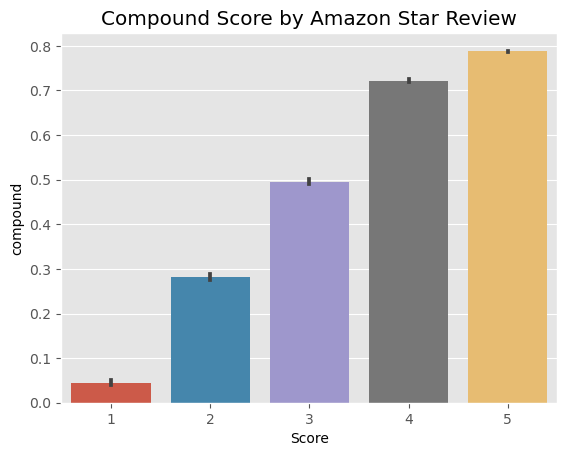

In [11]:
#Plot Vader Results
ax = sns.barplot(data=vaders, x ='Score', y = 'compound')
ax.set_title("Compound Score by Amazon Star Review")
plt.show()

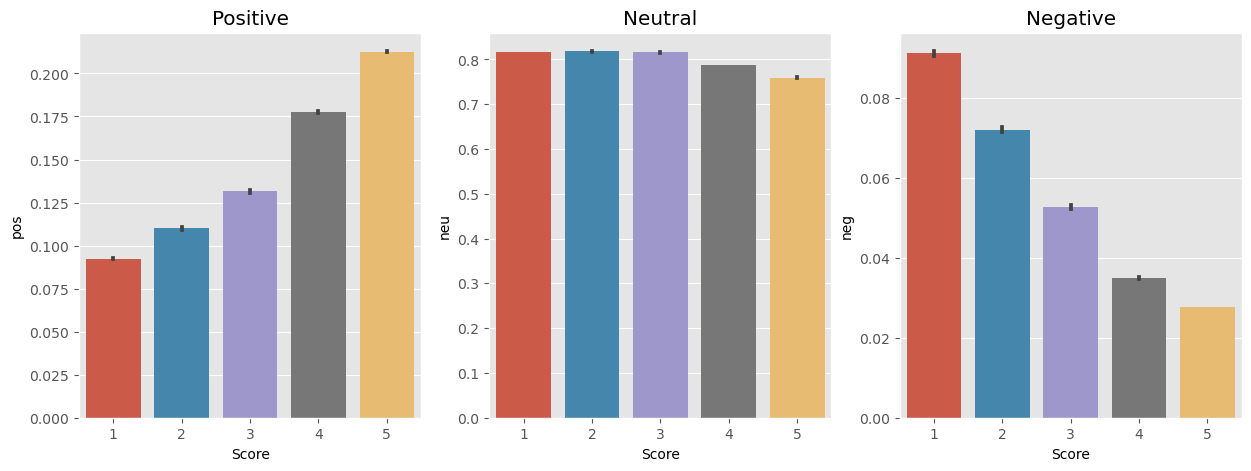

In [12]:
#Creates 1x3 grid of results
fig, axs = plt.subplots(1, 3, figsize = (15, 5))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()


In [19]:
#Step 3: Roberta Trained Model
#Uses a model trained of large corpus of data
#Accounts for words but also context of words in relation to other words
#Picks up on sarcasm for example

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax


In [21]:
#Pretrained model for sentimed provided by HuggingFace

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [23]:
#VADER Results on example
print(example)
sia.polarity_scores(example)

My English Bulldog had skin allergies the summer we got him at age 3.  The vet recommended we wean him off the food his previous owner gave him (Iams Lamb and Rice) and onto a new kind.  This was the second one we tried, and it has been working ever since.  It's for dogs that need a limited diet who can be sensitive to additives and proteins commonly found in commercial dog food (like chicken or beef).


{'neg': 0.023, 'neu': 0.884, 'pos': 0.093, 'compound': 0.7003}

In [27]:
#Run on Roberta Model

#Taking text and putting in 1s and 0s using pytorch for return tensors so model can understand
encoded_text = tokenizer(example, return_tensors='pt')

#Taking encoded text and running model on it (** packs data into dict)
output = model(**encoded_text)

#Takes output from being tensor and takes it into numpy so can be stored locally
scores = output[0][0].detach().numpy()

#Changes scale to max of 1, converting numbers into probabilities
scores = softmax(scores)

scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.09271869, 'roberta_neu': 0.5976608, 'roberta_pos': 0.30962053}


In [29]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [35]:
results = {}
longdf = df
df = longdf.head(1000)
for i, row in tqdm(df.iterrows(), total = len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
                vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        results[myid] = both
    except RuntimeError:
        print(f"The code broke for the following id: {myid}") 

  0%|          | 0/1000 [00:00<?, ?it/s]

The code broke for the following id: 83
The code broke for the following id: 187
The code broke for the following id: 529
The code broke for the following id: 540
The code broke for the following id: 746
The code broke for the following id: 863


In [37]:
results_df = pd.DataFrame(results).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.711,0.289,0.9441,0.009624,0.049980,0.940396,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.085,0.771,0.144,0.8138,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,0.932,0.068,0.4404,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.599,0.401,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [45]:
#Look at some examples
#Sentenced pretty nuanced, hart to know if positive or negative without knowing context
 results_df.query('Score == 1').sort_values('roberta_pos', ascending=False)['Text'].values[0]

"I just wanted to post here that I found small bits of plastic in this food as I was feeding my 9 month old.  Plastic!!! in food!!!! baby food!!!  So please be careful if you buy this or are considering it.<br /><br />My daughter LOVES this food-- it's actually her favorite.  This is the first time we have noticed plastic in it in over 2 months."

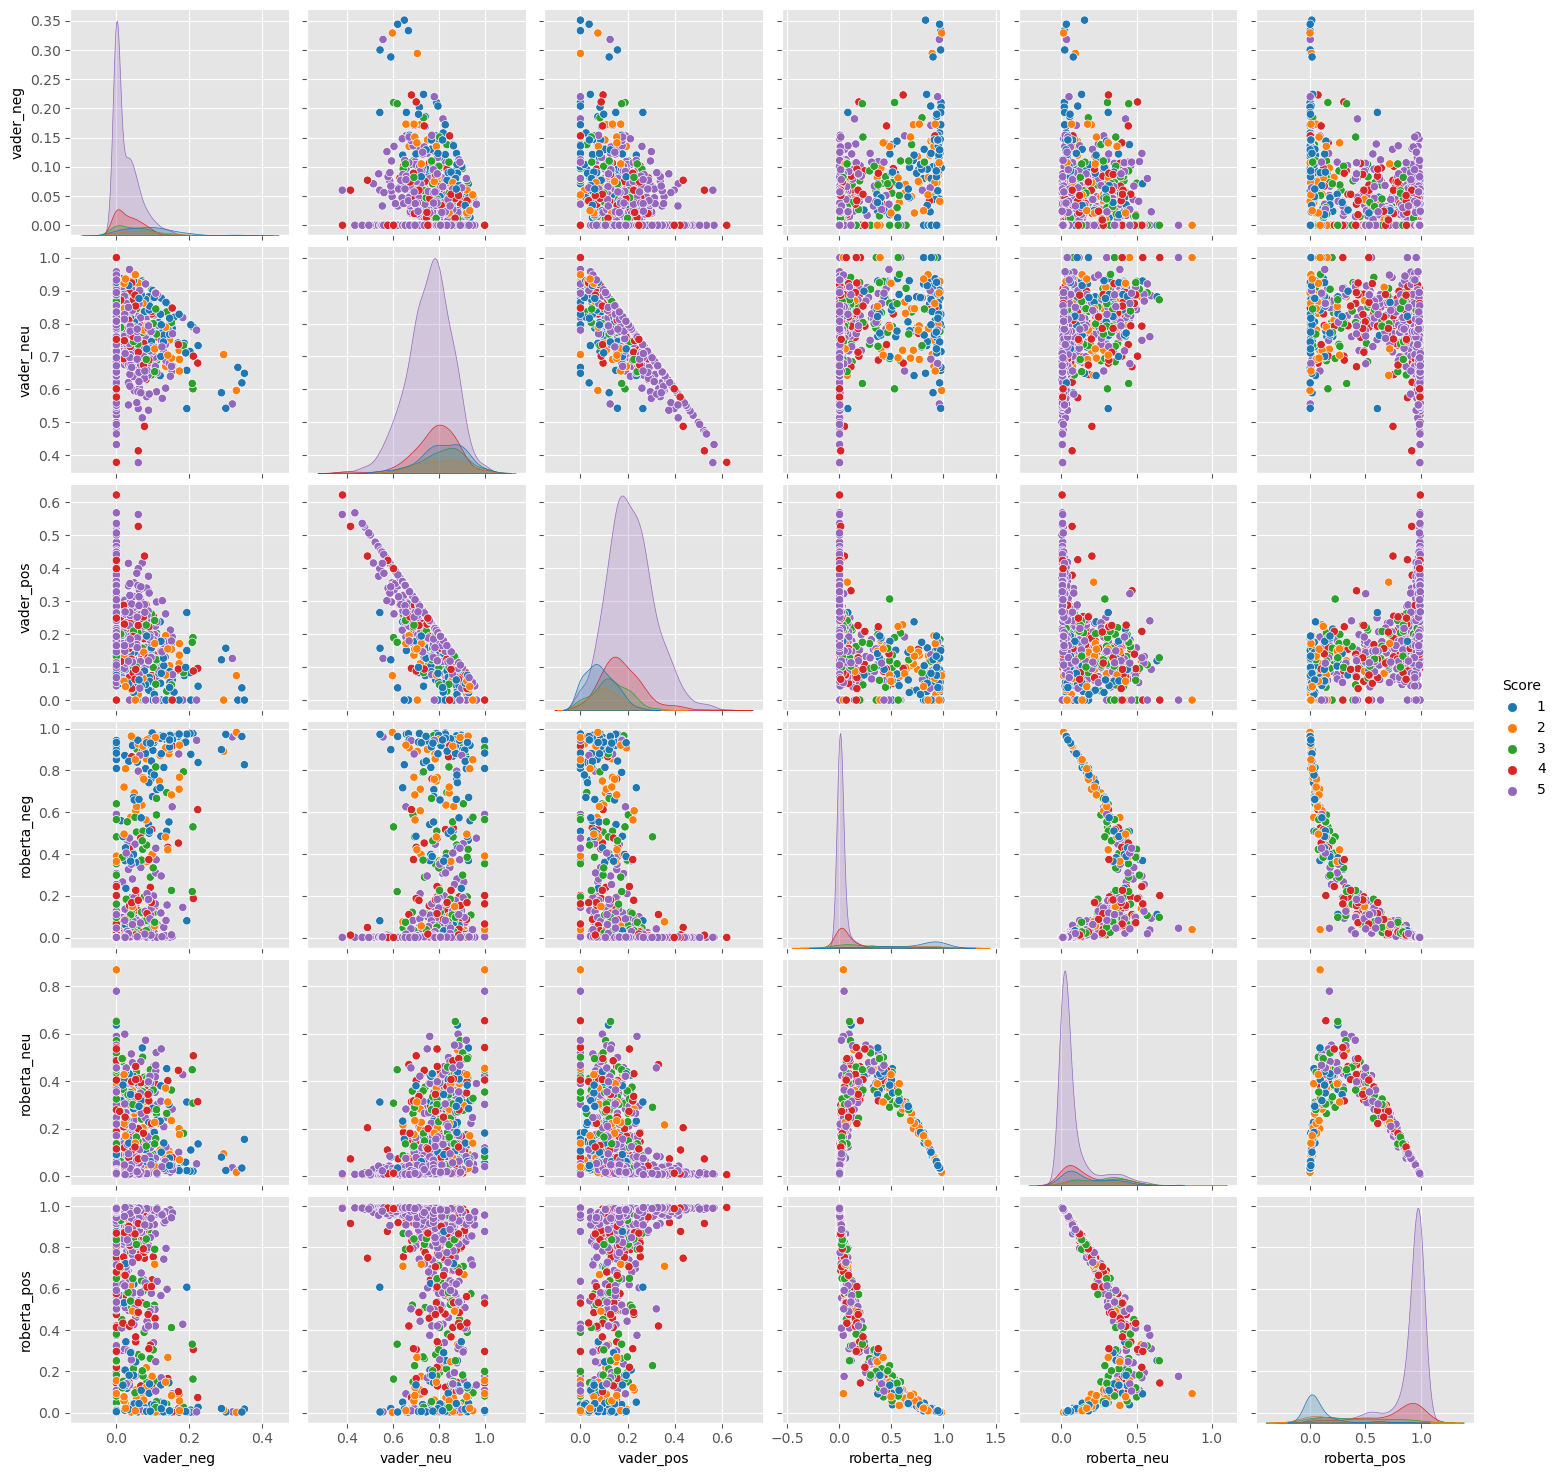

In [43]:
#Compare scores between Models
#Use pairplot which lets us see comparisons between observations/features
sns.pairplot(data = results_df, vars=['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos'], hue='Score', palette='tab10')
plt.show()